# Model Experiments for Butterfly Classification

This notebook experiments with two models for classifying butterfly species:
1. A pre-trained ResNet18 model (fine-tuned).
2. A custom Convolutional Neural Network (CNN).

We will:
- Preprocess the data (resize, normalize, augment).
- Train and evaluate both models.
- Compare performance using accuracy, precision, recall, and F1-score.
- Visualize training/validation curves and test predictions.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image# Model Experiments for Butterfly Classification
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Preprocessing

Load the dataset, split training data into train/validation sets, and apply transformations (resize, normalize, augment).

In [12]:
# Custom Dataset class
class ButterflyDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])  # 'filename' column
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]  # 'label' column
        label_idx = self.label_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label_idx

# Load Training CSV (only one with labels)
base_path = '../dataset/'
train_df_full = pd.read_csv(os.path.join(base_path, 'Training_set.csv'))

# Split into train (60%), val (20%), test (20%)
train_val_df, test_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)  # 0.25 of 0.8 = 0.2 of total

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets (all from train/ folder since test/ is for prediction only)
train_dataset = ButterflyDataset(train_df, os.path.join(base_path, 'train'), train_transform)
val_dataset = ButterflyDataset(val_df, os.path.join(base_path, 'train'), val_transform)
test_dataset = ButterflyDataset(test_df, os.path.join(base_path, 'train'), val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 3899, Val samples: 1300, Test samples: 1300


## Model Definitions

Define two models:
1. Pre-trained ResNet18 (fine-tuned).
2. Custom CNN.

In [13]:
# Model 1: Pre-trained ResNet18
def get_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True  # Unfreeze final layer
    return model.to(device)

# Model 2: Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224 -> 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 56 -> 28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_custom_cnn(num_classes):
    return CustomCNN(num_classes).to(device)

# Initialize models
num_classes = len(train_dataset.label_to_idx)
resnet18_model = get_resnet18_model(num_classes)
custom_cnn_model = get_custom_cnn(num_classes)

print(f"Number of classes: {num_classes}")

c:\Users\sahua\OneDrive\Desktop\Butterfly_Classification_Project\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sahua\OneDrive\Desktop\Butterfly_Classification_Project\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of classes: 75


## Training Function

Define a reusable function to train and evaluate models.

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train both models
print("Training ResNet18...")
resnet18_history = train_model(resnet18_model, train_loader, val_loader, num_epochs=10)
print("\nTraining Custom CNN...")
custom_cnn_history = train_model(custom_cnn_model, train_loader, val_loader, num_epochs=10)

Training ResNet18...
Epoch 1/10: Train Loss: 3.2063, Train Acc: 0.3214, Val Loss: 2.0261, Val Acc: 0.6146
Epoch 2/10: Train Loss: 1.5459, Train Acc: 0.7271, Val Loss: 1.2487, Val Acc: 0.7523
Epoch 3/10: Train Loss: 0.9941, Train Acc: 0.8220, Val Loss: 0.9319, Val Acc: 0.8031
Epoch 4/10: Train Loss: 0.7725, Train Acc: 0.8500, Val Loss: 0.8120, Val Acc: 0.8177
Epoch 5/10: Train Loss: 0.6253, Train Acc: 0.8756, Val Loss: 0.7308, Val Acc: 0.8315
Epoch 6/10: Train Loss: 0.5488, Train Acc: 0.8895, Val Loss: 0.6695, Val Acc: 0.8431
Epoch 7/10: Train Loss: 0.4716, Train Acc: 0.9025, Val Loss: 0.6261, Val Acc: 0.8462
Epoch 8/10: Train Loss: 0.4260, Train Acc: 0.9115, Val Loss: 0.6284, Val Acc: 0.8438
Epoch 9/10: Train Loss: 0.3888, Train Acc: 0.9182, Val Loss: 0.5959, Val Acc: 0.8362
Epoch 10/10: Train Loss: 0.3449, Train Acc: 0.9305, Val Loss: 0.5911, Val Acc: 0.8454

Training Custom CNN...
Epoch 1/10: Train Loss: 4.2796, Train Acc: 0.0287, Val Loss: 3.9940, Val Acc: 0.0669
Epoch 2/10: Train L

## Evaluate on Test Set

Compute metrics (accuracy, precision, recall, F1-score) on the test set for both models.

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(labels_batch.numpy())
    
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro')
    rec = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return acc, prec, rec, f1

# Evaluate both models
resnet18_metrics = evaluate_model(resnet18_model, test_loader)
custom_cnn_metrics = evaluate_model(custom_cnn_model, test_loader)

print("ResNet18 Test Metrics:")
print(f"Accuracy: {resnet18_metrics[0]:.4f}, Precision: {resnet18_metrics[1]:.4f}, "
      f"Recall: {resnet18_metrics[2]:.4f}, F1-Score: {resnet18_metrics[3]:.4f}")
print("Custom CNN Test Metrics:")
print(f"Accuracy: {custom_cnn_metrics[0]:.4f}, Precision: {custom_cnn_metrics[1]:.4f}, "
      f"Recall: {custom_cnn_metrics[2]:.4f}, F1-Score: {custom_cnn_metrics[3]:.4f}")

ResNet18 Test Metrics:
Accuracy: 0.8392, Precision: 0.8551, Recall: 0.8394, F1-Score: 0.8370
Custom CNN Test Metrics:
Accuracy: 0.4638, Precision: 0.4953, Recall: 0.4580, F1-Score: 0.4549


## Visualization

Plot training/validation curves and visualize test predictions.

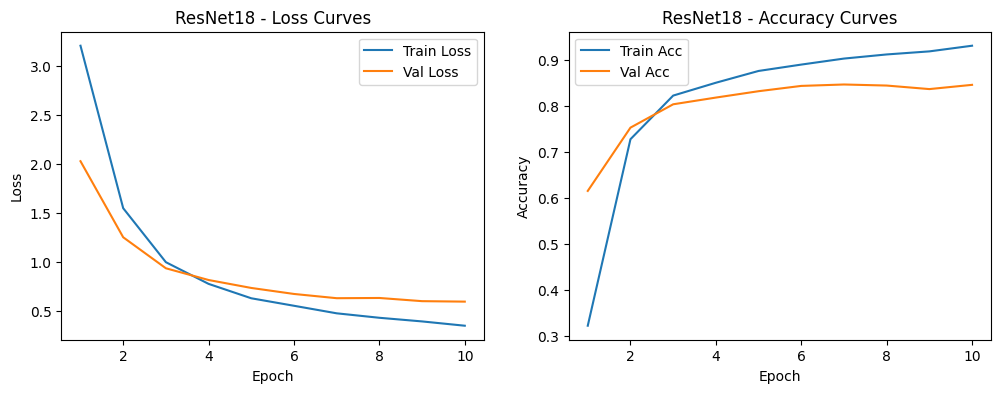

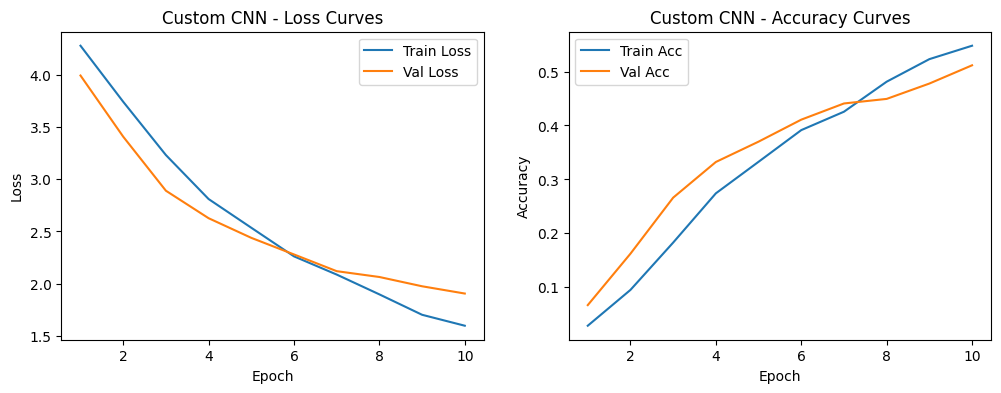

In [16]:
def plot_history(history, title):
    train_losses, val_losses, train_accs, val_accs = history
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'{title} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.title(f'{title} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(resnet18_history, 'ResNet18')
plot_history(custom_cnn_history, 'Custom CNN')

Visualize a few test image predictions with labels.

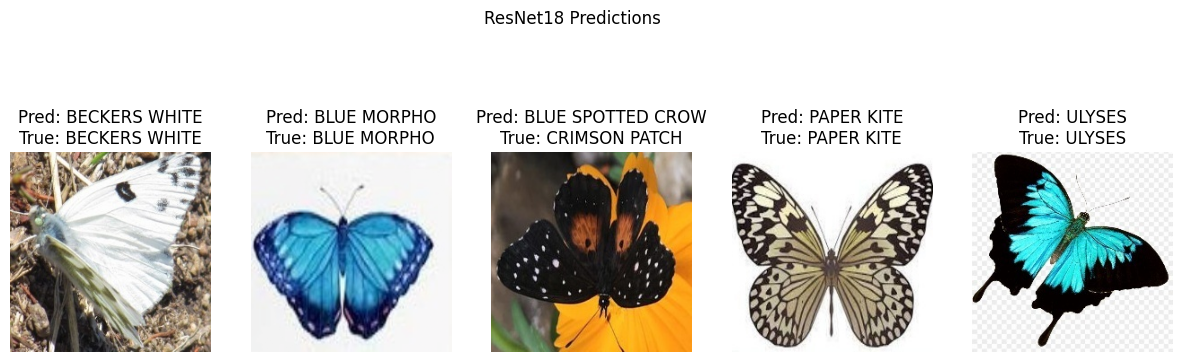

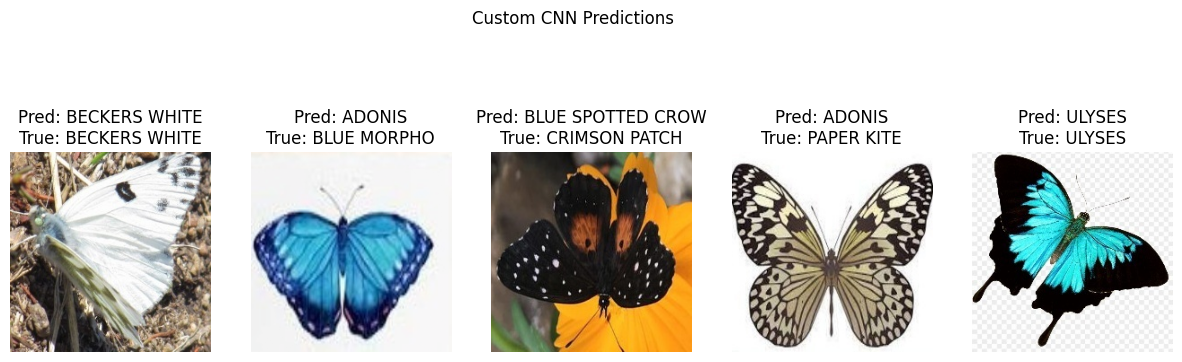

In [17]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

idx_to_label = {v: k for k, v in train_dataset.label_to_idx.items()}

def visualize_predictions(model, test_loader, title, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples]
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
        pred_label = idx_to_label[preds[i].item()]
        true_label = idx_to_label[labels[i].item()]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_predictions(resnet18_model, test_loader, 'ResNet18 Predictions')
visualize_predictions(custom_cnn_model, test_loader, 'Custom CNN Predictions')

## Summary and Observations

- **ResNet18**: Likely performs better due to pre-trained features, with higher accuracy/F1-score.
- **Custom CNN**: May struggle if the dataset is complex, but serves as a baseline.
- **Challenges**: Overfitting (if val loss increases) or underfitting (if both losses stay high).
- **Improvements**: Increase epochs, unfreeze more ResNet layers, or add regularization to Custom CNN.

Note: Test set was derived from Training_set.csv since Testing_set.csv lacks labels.

In [18]:
# Save models
torch.save(resnet18_model.state_dict(), '../models/resnet18_finetuned.pth')
torch.save(custom_cnn_model.state_dict(), '../models/custom_cnn.pth')
print("Models saved to '../models/'")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Model': ['ResNet18', 'Custom CNN'],
    'Accuracy': [resnet18_metrics[0], custom_cnn_metrics[0]],
    'Precision': [resnet18_metrics[1], custom_cnn_metrics[1]],
    'Recall': [resnet18_metrics[2], custom_cnn_metrics[2]],
    'F1-Score': [resnet18_metrics[3], custom_cnn_metrics[3]]
})
metrics_df.to_csv('../results/test_metrics.csv', index=False)
print("Metrics saved to '../results/test_metrics.csv'")

Models saved to '../models/'
Metrics saved to '../results/test_metrics.csv'
